# Py: Classifying review sentiment
**This notebook was originally created by Rob Daly for the Data Analytics Applications subject, as *Case study 7.1 - Classifying automative reviews* in the *DAA M07 Natural language processing* module.**

**Data Analytics Applications is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.**

**Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).**

### Purpose:
This notebook walks through the use of NLP to analyse customer sentiment. The objective of the case study is to identify 'complaints' from a sample of YELP reviews for automotive companies. YELP is a North American review service where customers review different service providers. Reviewers write a text review and are then asked to rate the service on a five point scale.

### References:
The dataset that is used in this case study was sourced from a Kaggle competition in which YELP provided a set of reviews: https://www.kaggle.com/yelp-dataset/yelp-dataset.

It contains information about businesses across 8 metropolitan areas in the USA and Canada.

For this case study, the dataset has been refined to contain 50,000 reviews for companies tagged as 'automotive'.

## Packages
This section installs packages that will be required for this exercise/case study.

In [1]:
import json # Json is used to load json files.
import os # os is used to join paths for windows and unix use.
import random # For random number generation.
import time # Useful for timing processes.

from collections import Counter # Counter provides a quick way to add items in a list.
from collections import defaultdict # Enhanced mapping dictionary that can take a default value.
import numpy as np # For mathematical operations.
import matplotlib.pyplot as plt # For plotting.

from nltk.tokenize import word_tokenize
  # 'word_tokenize' is a tokeniser for natural language.
  # There are many such options available.
import nltk
nltk.download('punkt')

# Sklearn has many useful machine learning packages.
# The following are used in the notebook.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Used to read files from a web URL
from urllib.request import urlretrieve

# Package used in the confusion matrix function.
import itertools


[nltk_data] Downloading package punkt to /Users/Jacky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Functions
This section defines functions that will be used for this exercise/case study.

In [2]:
# Define a function to load a json data file.
def load_json(data_set_name, dir = '', verbose=True):
    '''
    This is a function to load the yelp dataset which is stored in json format.
    Use the optional dir argument if the file is not in the same directory
    as the notebook.
    '''
    if verbose:
        print('loading', data_set_name, 'data ', end = '')
        # If the user has set Verbose = True (or omitted this argument),
        # these lines of code provide a message to the person running the code
        # that the dataset is being loaded.
    
    filename = os.path.join(dir, data_set_name)
    f = open(filename, encoding='utf8')

    data_set = list()
    for counter, line in enumerate(f):
        data_set.append(json.loads(line))
        
        if verbose and ((counter % 100000) == 0):
            print('.', end='')
            # If the dataset is very big, these lines of code print '.'s to
            # show that the import step is progressing.

    f.close()
    
    if verbose: 
        print(' {:,} observations have been imported.'.format(len(data_set)))
        # This statement summarises the number of observations that have been
        # imported from the dataset.
    
    return data_set

In [3]:
# Define a function to print the Yelp reviews neatly.
def print_review(review):
    for item in ['business_id', 'stars', 'funny', 'review_id', 'date', 'useful',
                 'user_id', 'cool']:
        print('{:<12s}: {:}'.format(item, review[item]))
    print ('text: "', review['text'], '"', sep = '')
    # The default for print() is to put a space between each argument. 
    # Here sep='' is used to overrule this.
    print()
    
    return

In [4]:
# Define a function to select reviews with a certain rating (number of stars).
def sample_with_rating(review_data, rating, sample_size):
    select_data = [data_row for data_row in review_data \
                   if data_row['stars'] == rating]
    review_sample = random.sample(select_data, sample_size)
    return review_sample

In [5]:
# Define a function to format the summary of review ratings.
def print_review_count(review_count):
    head_format = '{:<7s}  {:>10s} {:>10s}'
    row_format = '{:<7}  {:>10,} {:>10.1%}'
    
    print(head_format.format('Stars', 'Total', 'Percent'))
    print(head_format.format('-----', '-----', '-------'))
        
    total_reviews = sum([count for count in review_count.values()])

    # Add the percent to a dictionary indexed in the same way.
    review_perc = dict()
    for rating, review in review_count.items():
        review_perc[rating] = review/total_reviews
    
    for k in range(5, 0, -1):
        print(row_format.format(('*'*k), review_count[k], review_perc[k]))

    print(head_format.format('','-------','-------'))
    print(row_format.format('Total', total_reviews, 1))

In [6]:
# Define a function to print some example reviews based on a user input
# of 'min', 'max', 'average' etc summary function.
def print_certain_reviews(data, summ_func, descr):
    # The 'summ_func' will be 'min', 'max', 'average', 'median' etc.
    certain_review = summ_func([length for (review, length) in data])
    reviews = [review for (review, length) in data if length == certain_review]
    review_count = len(reviews)
    if review_count == 1:
        print("Below is the 1 {:s} review of {:,} words:".format(descr, certain_review))
    else:
        print("Below are the {:,} {:s} reviews of {:,} words:".format(review_count, descr, certain_review))
      
    for review in reviews:
        print('"',review,'"')
    print()

In [7]:
# Define a function to perform the Bag of Words vectorisation.
def vectorise_data(data_set, vocab):
    matrix = []
    for k, review in enumerate(data_set):
        if k % 1000 == 0:
            print('.', end='')
            # Prints '.' every 1,000 reviews so that you
            # know the code is still running.
        token_count = Counter(review['tokens'])
            # Create a count of all the unique tokens in the review.
        matrix.append([token_count.get(token, 0) for token in vocab])
            # The token counts for the review are added to 'matrix'. 
            # The 'get' function of Counter is used to return a 0
            # for any tokens in the vocabulary that are not in a review.
    print()
    
    return matrix

In [8]:
# Define a function to calculate a range of success metrics for a fitted model.
def return_metrics(y, y_pred):
    scores = dict()
    scores['Accuracy'] = metrics.accuracy_score(y, y_pred)
    scores['F1-score'] = metrics.f1_score(y, y_pred, average='binary', pos_label=True)
    scores['Precision'] = metrics.precision_score(y, y_pred, pos_label=True)
    scores['Recall'] = metrics.recall_score(y, y_pred, pos_label=True)   
    scores['Confusion Matrix'] = metrics.confusion_matrix(y, y_pred)

    return scores

In [9]:
# Define a function to plot confusion matrices in an easy to visualise format.
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots a nicely formatted confusion matrix.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True response')
    plt.xlabel('Predicted response')

In [10]:
# Define a function to print out the success metrics of a model.
def print_scores(scores, confused = False):
    print(('{:^9} '*4).format(*scores.keys()))
    print(('{:^9.1%} '*4).format(*scores.values()))

    if confused:
            plot_confusion_matrix(scores['Confusion Matrix'],
                                   classes = ['Non-complaint', 'Complaint'])

## Data
This section:
- imports the data that will be used in the modelling;
- explores the data; and
- prepares the data for modelling.

### Import data


In [11]:
# Specify the URL of the dataset to be imported.
url = 'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/DAA_M07_CS1_data.json'

urlretrieve(url, "DAA_M07_CS1_data.json")

('DAA_M07_CS1_data.json', <http.client.HTTPMessage at 0x1297bdca0>)

In [12]:
# Read the required YELP file.
review_data = load_json("DAA_M07_CS1_data.json")

# Alternatively, use the code below with Google Colab to upload the file
# from your computer.

# from google.colab import files
# files.upload()
  # When prompted, select the DAA_M07_CS1_data.json dataset to upload.
  # Note that this may take some time to upload as the file is large.
# review_data = load_json('DAA_M07_CS1_data.json')

loading DAA_M07_CS1_data.json data . 50,000 observations have been imported.


### Explore data (EDA)
The following data exploration is performed below:
- look at the features available in the data;
- show some example reviews;
- see how many reviews there are in each rating category; and
- look at how long the reviews are.


In [13]:
# Extract the feature names from the data.
features = {key for review in review_data for key in review.keys()}
  # The '{}' brackets are used to define a set that contains unique entries.
print(features)

# The feature names could also be obtained used a for loop per the code below.
# This is a less efficient way of extracting the information.
features2 = set() # This creates an empty set.
for review in review_data:
    for key in review.keys():
        features2.add(key)
print(features2)

{'user_id', 'date', 'review_id', 'text', 'funny', 'business_id', 'useful', 'cool', 'stars'}
{'user_id', 'date', 'review_id', 'text', 'funny', 'business_id', 'useful', 'cool', 'stars'}


In [14]:
# Print a sample of 5 random reviews from the full dataset.
review_sample = random.sample(review_data, 5)
  # The 'sample' method in the 'random' package selects, without replacement,
  # the number of items you want from a list.

for review in review_sample:
    print_review(review)

business_id : MqcUTJ6T_DsJVBreh5r68g
stars       : 5.0
funny       : 1
review_id   : DbOWQ9bysVDBo9ILkWZf6g
date        : 2019-06-26 14:03:43
useful      : 0
user_id     : OJz7Rbav0tm1AAXwArGE6A
cool        : 0
text: "Well Just picked up 4th vehicle that has gone to Notorious. Also referred a number of friends to them. Quality work, come up with great ideas on little details, shop and staff are unreal and pricing is fair but you get what you pay for! Will be dropping off #5 as soon as it gets delivered!"

business_id : H7mjnD5AZoMZDyNjUEcVDg
stars       : 5.0
funny       : 0
review_id   : v1153so3LG3Pfbd0ojx6IA
date        : 2011-08-15 21:37:48
useful      : 0
user_id     : JV1lIvs4oUevaPJh5O4Yqw
cool        : 1
text: "Had the guys from suburban come out and install  shower glass and a wall to wall mirror for us, they did a great job for us. When we had an issue with one of the shower pieces and they came right away and fixed it for us at no additional charge."

business_id : ApG6TS7aD

In [15]:
# Print 5 random reviews with 1 star ratings using the
# 'sample_with_rating' function defined at the top of the notebook.
review_sample = sample_with_rating(review_data, rating=1, sample_size=5)
for review in review_sample:
    print_review(review)

business_id : hKC0ZeoiCUmYCsJVTAQEgQ
stars       : 1.0
funny       : 0
review_id   : DjkV7-E7wngueXpeI1DGjQ
date        : 2013-10-18 12:51:01
useful      : 2
user_id     : hm1MLz1yJV--ceZG4RY1oA
cool        : 0
text: "Had an unexpected brake problem with my Honda. Called in advance to see if they could look at my vehicle that day. Had it towed in and it took them two days to put new brakes on. I never received an estimate. Every time they gave me that it would be completed they missed. They called at 4:45 and said it was almost done. When I arrived one hour later it still was not done. And as I pulled out of the parking lot I noticed my clock and radio were not working and need to be reset. How can a brake job affect your radio?! I wouldn't trust these fools to put air in my tires. Overpriced, under deliver, disrespectful and incompetent. BEWARE!"

business_id : 4r_oR7zo2oV0_BGlAN6ltw
stars       : 1.0
funny       : 0
review_id   : jw5_7C9XQZyHLem6oEw9iw
date        : 2017-02-11 19:23:

In [16]:
# Count the number of reviews in each rating category.
# This is done using a counter as an efficient method to iterate through items.

review_count = Counter([review['stars'] for review in review_data])
  # A list constructor is used to produce a list of all the star ratings
  # and the Counter function is then used to count how many reviews there are
  # in each star rating group.

print_review_count(review_count)

Stars         Total    Percent
-----         -----    -------
*****        27,101      54.2%
****          3,915       7.8%
***           1,790       3.6%
**            2,470       4.9%
*            14,724      29.4%
            -------    -------
Total        50,000     100.0%


In [17]:
# Check the length of different reviews.
# A list constructor is used to produce a list of how long each review is
# in characters. 
review_length_characters = [len(review['text']) for review in review_data]

# Print summary statistics for the number of characters in each review.
print('The longest character length in a review is {:,}.'.format(max(review_length_characters)))
print('The shortest character length in a review is {:,}.'.format(min(review_length_characters)))
print('The average character length of reviews is {:.0f}.'.format(np.mean(review_length_characters)))
print('The median character length of reviews is {:.0f}.'.format(np.median(review_length_characters)))
print()

# A list constructor is used to produce a list of how long each review is
# in words.
review_length_words = [len(review['text'].split()) for review in review_data]
  # The str.split() function breaks a string by approximate word breaks. 

## Print summary statistics for the number of words in each review.
print('The longest word length in a review is {:,}.'.format(max(review_length_words)))
print('The shortest word length in a review is {:,}.'.format(min(review_length_words)))
print('The average word length of reviews is {:.0f}.'.format(np.mean(review_length_words)))
print('The median word lenth of reviews is {:.0f}.'.format(np.median(review_length_words)))

The longest character length in a review is 5,000.
The shortest character length in a review is 1.
The average character length of reviews is 630.
The median character length of reviews is 436.

The longest word length in a review is 1,051.
The shortest word length in a review is 1.
The average word length of reviews is 119.
The median word lenth of reviews is 82.


In [18]:
# Print some examples of the shortest and longest reviews.
review_and_length = [(review['text'],len(review['text'].split())) for review in review_data]

print_certain_reviews(review_and_length, min, 'shortest')
print_certain_reviews(review_and_length, max, 'longest')

Below are the 4 shortest reviews of 1 words:
" L "
" Great! "
" :) "
" :) "

Below is the 1 longest review of 1,051 words:
" CAUTION!!!!!! DO NOT GO HERE!!!! If I could I'd give this place a -5 star!!! That's the first red flag u should know. I have a long story & from reading ALOT of reviews id say about 98% of them r poor reviews about this place. About 5 of them r very similar to mine. So here's my horrible story and experience...It was last month in Oct of 2015 ,I've been hearing about the Tent sale on 83rd between Bell rd & T-bird. Sale started Oct 22nd. So I have a 2014 Crystler 200 & it was my first car I've owned, by this time I had it for about 7 months. My heart was set on a Kia Optima but ended up settling for the 200. So when we get there we are given a person to take us around to look at cars. We were with 2 guys, Brian & Tavo from Vans Chevy. Before I go on, Tavo is an amazing nice guy that is very honest, very helpful so I have nothing bad to say about Tavo. Anyways, Bri

In [19]:
# Print the 20 most common words across the whole corpus of complaints.
word_count = Counter([word for review in review_data for word in review['text'].split()])
print("{:<6} {:>12}".format("Word", "Count"))
print("{:<6} {:>12}".format("----", "----------"))
for word, count in word_count.most_common(20):
    # 'most_common' is a helpful method that can be applied to Counter.
    print("{:<6} {:>12,}".format(word, count))

Word          Count
----     ----------
the         227,409
and         201,289
I           194,839
to          183,683
a           138,253
was          92,536
my           89,669
for          70,787
in           65,321
of           65,069
that         55,917
they         55,752
it           54,209
car          49,644
me           48,401
with         46,183
is           45,623
on           44,690
have         39,543
you          34,432


### Prepare data
This section performs the following NLP tasks:
- tokenisation;
- splitting the data into training and test sets;
- defining the response variable;
- creating the vocabulary;
- cleaning; and
- vectorisation.


#### Tokenise

In the data exploration sections above, tokenising was performed using the Python str function 'split'. This function splits on white space and does not, for example, tokenise end of sentence markers such as '?' or '.' .

The 'word_tokenize' tokeniser from the nltk package can provide a better tokenisation outcome than the 'split' function because it identifies items such as end of sentence markers.

In [20]:
t0 = time.time()
  # This sets the starting time so the time taken
  # to tokenise can be measured.

# Tokenise the reviews using 'word_tokeniser'.
for counter, review in enumerate(review_data):
    if counter % 1000 == 1:
        print ('.', end='')
        # This prints a '.' every 1,000 reviews to reassure
        # you that the code is still running.
    review['tokens'] = word_tokenize(review['text'])
        # word_tokenize is an nltk tokeniser.
        # The set of tokens from each review is added to the review
        # dictionary under a new dictionary index 'tokens'.
print()

print("Tokenising took {:.0f} seconds".format(time.time()-t0))
print()

# Look at five sample sets of tokens across the whole data set.
review_sample = random.sample(review_data, 5)
for review in review_sample:
    print(review['text'])
    print(review['tokens'], '\n')


..................................................
Tokenising took 45 seconds

The service department at North Hills Toyota is absolutely terrible. A car inspection took almost 2 hours. The staff sit around and play in their phones the entire time. They do not come check up on you or provide an update on your service. I will forever go to Kenny Ross in Moon.
['The', 'service', 'department', 'at', 'North', 'Hills', 'Toyota', 'is', 'absolutely', 'terrible', '.', 'A', 'car', 'inspection', 'took', 'almost', '2', 'hours', '.', 'The', 'staff', 'sit', 'around', 'and', 'play', 'in', 'their', 'phones', 'the', 'entire', 'time', '.', 'They', 'do', 'not', 'come', 'check', 'up', 'on', 'you', 'or', 'provide', 'an', 'update', 'on', 'your', 'service', '.', 'I', 'will', 'forever', 'go', 'to', 'Kenny', 'Ross', 'in', 'Moon', '.'] 

I agree with Jesse, wholeheartedly. 

I'm sorry for those of you silver-spooners with a narrow and socially constricted view of the world. Let's hope none of you experience th

#### Clean data
The 'word_tokenize' tokeniser distinguishes between upper and lower case words such that 'Great' and 'great' are considered as two separate tokens. For this data set, such distinction between case may not be warranted and the model might perform better if all words are converted to their lower case form.
This is done in the code below.

In [21]:
# Convert the tokens for each review to lower case.
for review in review_data:
    review['tokens'] = [token.lower() for token in review['tokens']]

# Look at another five sample sets of lower case tokens across the whole data set.
review_sample = random.sample(review_data, 5)
for review in review_sample:
    print(review['text'])
    print(review['tokens'], '\n')

Took the finance people 2.5 hours to get around to physically accepting our check. We were just buying a cheap car, though, for a college kid so the lack of care kinda makes sense. This is more of a place looking shake down people; while we waited I got to listen to a sales guy running game on some old man, adding onto the price based on color choice. When we finally got in to hand over the check, the same sales guy burst in to interrupt for his own deal, so we waited a bit longer. Go figure...
['took', 'the', 'finance', 'people', '2.5', 'hours', 'to', 'get', 'around', 'to', 'physically', 'accepting', 'our', 'check', '.', 'we', 'were', 'just', 'buying', 'a', 'cheap', 'car', ',', 'though', ',', 'for', 'a', 'college', 'kid', 'so', 'the', 'lack', 'of', 'care', 'kinda', 'makes', 'sense', '.', 'this', 'is', 'more', 'of', 'a', 'place', 'looking', 'shake', 'down', 'people', ';', 'while', 'we', 'waited', 'i', 'got', 'to', 'listen', 'to', 'a', 'sales', 'guy', 'running', 'game', 'on', 'some', 'o

#### Split into training and test data

Now the data is partioned into a training and a test set. The chosen partion is 50% training and 50% test. This is because the dataset is quite large, with 
50,0000 reviews and having a large training set can cause Colab to crash when fitting the model. In practice, if RAM was not an issue, you might want to fit the model with more training data using, for example, an 80%/20% split.

Note that as has been shown in previous case studies in this subject, you might want to further split the training data into a training and validation set. The validation dataset can then be used to select different hyperparameters for your model. Alternatively, cross-validation can be used on the training data to help you select these hyperparameters.

This further splitting of the training data into a training and validation data set has been omitted from this case study.

In [22]:
train, test = train_test_split(review_data, test_size = 0.5)
  # The Sklearn package 'train_test_split' is used to automate this step. 
print(('{:>10s}'*3).format('training', 'test', 'total'))
print(('{:10,}'*3).format(len(train), len(test), len(review_data)))

  training      test     total
    25,000    25,000    50,000


#### Define response

In [23]:
# Define the response variable as 1 (a complaint) if the number of stars given
# is 1 or 2. Otherwise define the response as 0 (non complaint).
train_y = [review['stars']<3 for review in train]
test_y = [review['stars']<3 for review in test]

# Check the total number of complaints is still the same
# across the training and test sets.
print(sum(train_y+test_y))
print(review_count[1]+review_count[2])

17194
17194


#### Create vocabulary
A vocabulary is created, based on all reviews in the training dataset (the corpus).
Note that the test data is not used to create the vocabulary as this is 'held out' until the end of the modelling process to test how well the model performs on unseen data.

In [24]:
# Create the vocabulary 
vocab_count = Counter([token for review in train for token in review['tokens']])
print('The vocabulary has {:,} tokens'.format(len(vocab_count)))
print('Some examples are: ')
print('{:6s} {:s} '.format('Count', 'Token'))
for token in random.sample(list(vocab_count), 50):
    print('{1:6,} {0:s} '.format(token, vocab_count[token]))

The vocabulary has 39,391 tokens
Some examples are: 
Count  Token 
   115 jose 
    10 eaten 
     1 black/red 
     2 42,000 
     1 sc430 
     2 10:50 
     2 brookpark 
     5 mangers 
     1 averaged 
     1 dilligence 
     7 engineering 
   126 regret 
     3 vancouver 
     1 ambassor 
     1 zeros 
     2 farid 
    13 calmly 
     5 prick 
     1 95k 
    43 constant 
     1 problemo 
    33 signal 
     1 pinching 
     3 deadlines 
    18 managing 
     1 tarde 
     4 crossover 
     1 concentrating 
     8 cindy 
     2 coughed 
     1 betos 
     2 flashy 
     1 inputting 
     1 leeper 
     1 piercy 
     1 maxx 
     1 5/10/19 
     1 kozak 
     2 chemically 
     2 d/t 
     5 aesthetic 
     9 cube 
     1 augie 
     1 airbag-related 
     4 mixture 
     9 rap 
     3 imbeciles 
     1 up-charge 
     3 deion 
     1 bern 


The vocabulary is large, with many unique tokens. The code below reduces the vocabulary to only include tokens that appear a certain number of times in the training corpus. The count of each word is not needed after this point so this is also dropped in the code below. 

The minimum count for a token to be retained in the vocabulary is a model parameter that can be varied later when tuning the model.

In [25]:
# Define the minimum count for a token to be retained.
min_count = 15

# Reduce the size of the vocabulary.
vocab = {token for token, count in vocab_count.items() if count >= min_count}

print('There are {:,} tokens used {:n} or more times. Some examples are:'.
      format(len(vocab), min_count))
for token in random.sample(tuple(vocab), 20):
    print(token)

There are 6,196 tokens used 15 or more times. Some examples are:
austin
american
constant
mechanical
guests
perhaps
hardest
ignored
aligned
service
due
cons
mine
l
leadership
sent
straight
canceling
9:00
promise


In [26]:
# Convert the reduced vocab into a dictionary to make it easier to check each column
# of the matrix later.
vocab = {token: k for k, token in enumerate(vocab)}

#### Vectorise

This section vectorises the tokens in the corpus using the Bag of Words approach. This involves creating a vector, for each review, that is as long as the corpus's vocabulary. The vector for each review shows how often each word in the vocabulary appears in the review.

For example, assume a vocabulary contains the letters 'a' to 'e'. The text 'a, b, b, c, d' would be vectorised as follows:
{a:1, b:2, c:1, d:1, e:0}.


In [27]:
# Vectorise the training and test data.
train_X = vectorise_data(train, vocab)
test_X = vectorise_data(test,vocab)

.........................
.........................


In [28]:
# Create a scaler so that the features in the dataset (the vectorised tokens)
# can be scaled to have a mean of 0 and a standard deviation of 1.
# Even though the features in this dataset are all on the same scale already,
# this step can sometimes help a model converge on an optimal solution
# faster during the fitting process.
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.fit_transform(test_X)

## Modelling

A logistic regression model is now trained. The aim of this model is to predict whether a review is a complaint (i.e. has less than 3 stars) based on the vectorised features for each review.

In [29]:
# Specify the model.
model = LogisticRegression(C = 5, solver = 'sag', verbose=1, max_iter=1000)
  # This line of code creates a logistic regression model.
  # 'C' is the inverse of regularisation strength and must be a positive float;
  # smaller values of C specify stronger regularisation.
  # solver = 'sag' specifies that the stochastic average gradient descent solver
  # should be used to optimise the parameters of the model.  
  # The model can be tuned by selecting different values for C and
  # also by specifying other parameters for the LogisticRegression module.

# Fit the model.
model.fit(train_X, train_y)
  # The training data can be supplied in several formats including
  # a list of lists (a matrix) for the X data and a list for the y data or
  # numpy arrays.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1199 seconds


/Users/Jacky/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.0min finished


LogisticRegression(C=5, max_iter=1000, solver='sag', verbose=1)

The warning message given above suggests that the model did not converge on an optimal solution after the maximum number of iterations (100) was performed. You could experiment with the model parameters to see if an optimal solution can be found.
Either way, the evaluation section below suggests that the solution found, while not necessarily optimal, is still reasonably good.

In [30]:
# Make predictions using the reviews in the test dataset.
pred_y = model.predict(test_X)

## Evaluate model
The next section prints key metrics for the predictions.

Accuracy  F1-score  Precision  Recall   
  93.1%     90.0%     90.9%     89.0%   


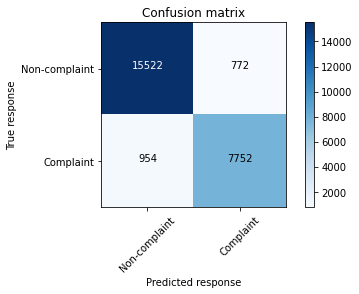

In [31]:
# Use the return_metrics and print_scores functions defined at the top
# of the notebook to review how well this logistic regression model
# has predicted complaints and non-complaints.
scores =  return_metrics(test_y, pred_y)
print_scores(scores, confused = True)

The results are reasonably good, with all printed metrics in the order of 90% or higher.

This suggests that the model has identified a high proportion of both true complaints and true non-complaints and a low proportion of false complaints and false non-complaints.

The AUC for the model is:  0.9215204981314656


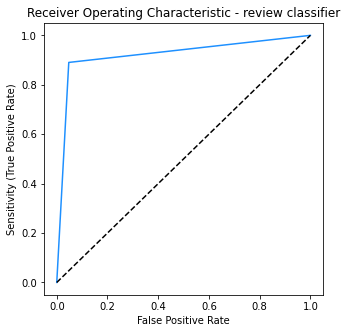

In [32]:
# Print a ROC curve and calculate the AUC for the model.
print('The AUC for the model is: ', metrics.roc_auc_score(test_y, pred_y))

# Retrieve the sensitivity (true positive rate) and false positive rate for
# each threshold value (where the threshold value decides how high the
# predicted probability of being a complaint has to be before an observation
# is classified as a complaint.)

false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(test_y, pred_y)
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - review classifier')
plt.plot(false_positive_rate, true_positive_rate,color='dodgerblue')
plt.plot([0, 1], ls="--",color='black')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()

It is instructive to see which tokens have the greatest and smallest weights in the fitted model. The greatest weights imply that these words predict complaints while the smallest weights show that these words predict non-complaints.

In [33]:
# Retrieve the weights from the model for each token in the vocabulary.
def print_by_weight(model, vocab, k = 5, verbose = True):
    mod_coefs = model.coef_
    
    # Create a list of vocab words and their weights.
    token_weight = list()
    for token, count in vocab.items():
        token_weight.append((token, mod_coefs[0, count]))
   
    # Sort and print the top k items.
    def print_list(tokens):
        print('{:20s}  {:>7s}'.format('Word', 'Weight'))
        print('{:20s}  {:>7s}'.format('----', '------'))
        for token in tokens:
            print ('{:20s}  {:7.1f}'.format(*token))
        print()
        return

    token_weight.sort(key = lambda x : x[1], reverse = True)
    complaint_keywords = token_weight[:k]
    print('Words driving complaints:')
    print_list(token_weight[:k])
    
    token_weight.sort(key = lambda x : x[1])
    non_complaint_keywords = token_weight[:k]
    print('Words driving non-complaints:')
    print_list(token_weight[:k])

    return complaint_keywords, non_complaint_keywords

complaint_keywords, non_complaint_keywords = print_by_weight(model, vocab, 10)

Words driving complaints:
Word                   Weight
----                   ------
worst                     1.7
horrible                  1.7
rude                      1.6
terrible                  1.6
avoid                     1.4
poor                      1.3
beware                    1.1
unprofessional            0.9
disappointed              0.9
elsewhere                 0.9

Words driving non-complaints:
Word                   Weight
----                   ------
excellent                -1.5
amazing                  -1.4
awesome                  -1.4
thank                    -1.4
great                    -1.3
best                     -1.3
highly                   -1.2
honest                   -1.2
quick                    -1.2
fair                     -1.2



## Comments

The model fitted provides a reasonable prediction of whether each review is a complaint (less than 3 stars) or a non-complaint (3 or more stars). The output of the model also makes sense in that the top 'complaint' words all have clear negative sentiment and the top 'non-complaint' words all have clear positive sentiment.

As an exercise, you should experiment with the tokenisation of reviews by trying the following:
- remove standard stop words; and
- perform stemming or lemmatisation.

You may like to review the code in Case Study 2 first and then come back to try the above.